## Face and Facial Keypoint detection

After you've trained a neural network to detect facial keypoints, you can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` you created and applied in Notebook 2, whose job was tp rescale, normalize, and turn any iimage into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

In the next python cell we load in required libraries for this section of the project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#%load_ext autoreload
#%autoreload 2

#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

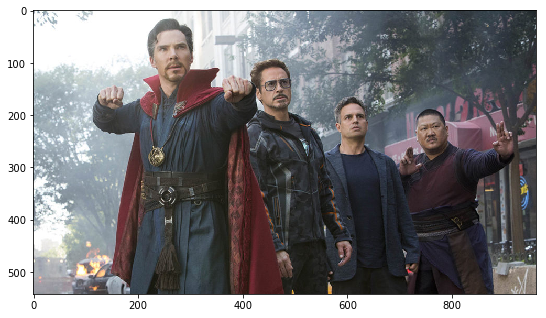

In [2]:
import cv2
# load in color image for face detection
#image = cv2.imread('images/obamas.jpg')
#image = cv2.imread('images/the_beatles.jpg')
image = cv2.imread('images/avengers2.jpg')
#image = cv2.imread('images/trump.jpg')


if(image.shape[2] == 4):
    image = image[:,:,0:3]
    
# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

Next, you'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). You can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detection on a variety of images is shown below.

<img src='images/haar_cascade_ex.png' width=80% height=80%/>


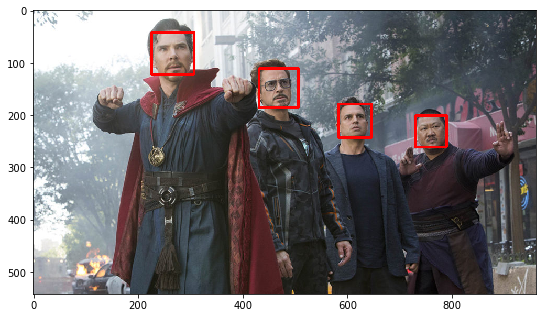

In [3]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
#faces = face_cascade.detectMultiScale(image, 1.2, 2)
faces = face_cascade.detectMultiScale(image, 1.2 ,5)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

## Loading in a trained model

Once you have an image to work with (and, again, you can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into your CNN facial keypoint detector.

First, load your best model by its filename.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from models import Net
#from models_v2 import Net
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils,models
# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset,FacialKeypointsInferenceDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor,Brightness

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)

net = Net()
#net.to(device)
net.load_state_dict(torch.load('saved_models/2018-05-06-22-34-38_keypoints_model_e400_64_l_0.0002.pt'))

## print out your net and prepare it for testing (uncomment the line below)

net.eval()

cuda:0


Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 40, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(40, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4_drop): Dropout(p=0.3)
  (fc1): Linear(in_features=15488, out_features=5000, bias=True)
  (fc1_drop): Dropout(p=0.3)
  (fc2): Linear(in_features=5000, out_features=136, bias=True)
)

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

### Transform each detected face into an input Tensor

You'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

You may find it useful to consult to transformation code in `data_load.py` to help you perform these processing steps.


###  Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for your network to see as input, you'll wrap that Tensor in a Variable() and can apply your `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display, and you may find it helpful to write a helper function like `show_keypoints`. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:

<img src='images/michelle_detected.png' width=30% height=30%/>




In [17]:
scalesize = 250
cropsize = 224

In [6]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    #plt.scatter(86, 149, s=20, marker='x', c='m')

    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

In [7]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(10,6))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        #print(image.shape)
        #image = image.cpu().numpy()  #for GPU to CPU
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        #print(predicted_key_pts.shape)
        predicted_key_pts = predicted_key_pts.numpy()
        #predicted_key_pts = predicted_key_pts.cpu().numpy()
        #print(predicted_key_pts.shape)

        # undo normalization of keypoints
        mean  = cropsize/2#50#100,50
        std   = cropsize/2#15#50,15
        print(mean,std)
        predicted_key_pts = predicted_key_pts*std+mean
        print(predicted_key_pts[0])
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*std+mean
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        #plt.axis('off')

    plt.show()

582 179 64 64
torch.Size([1, 1, 224, 224])
tensor(-0.4669)
112.0 112.0
[  59.71021271  105.57566833]


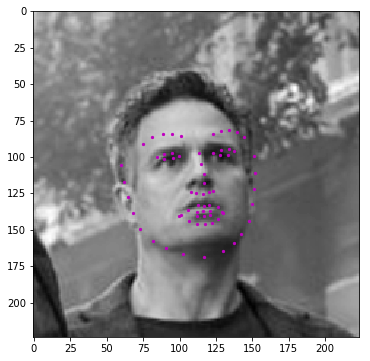

431 111 75 75
torch.Size([1, 1, 224, 224])
tensor(-0.4969)
112.0 112.0
[  56.34848022  105.77386475]


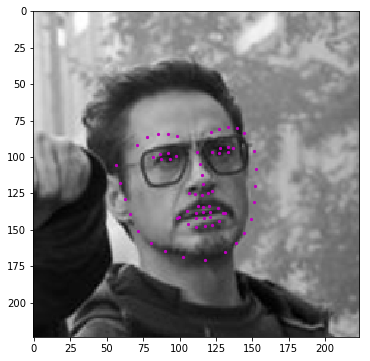

226 42 81 81
torch.Size([1, 1, 224, 224])
tensor(-0.4917)
112.0 112.0
[  56.92928696  108.54961395]


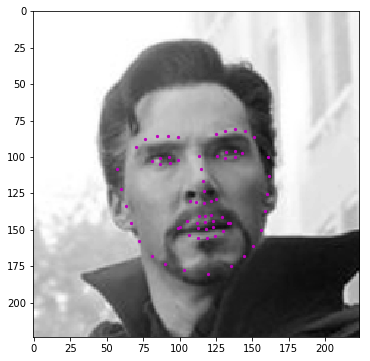

729 201 60 60
torch.Size([1, 1, 224, 224])
tensor(-0.4276)
112.0 112.0
[  64.10623169  109.14266968]


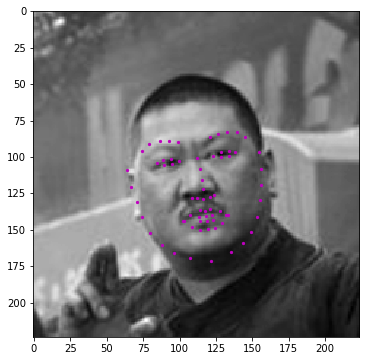

In [8]:
image_copy = np.copy(image)
feature_map=[]
roi_ori = None
#new_w, new_h = cropsize,cropsize
# loop over the detected faces from your haar cascade
for (x,y,w,h) in faces:
    
    # Select the region of interest that is the face in the image
    print(x,y,w,h)

    #deltax = int((scalesize - w)/2)
    #deltay = int((scalesize - h)/2)
    deltax = 40
    deltay = 40

    #roi = image_copy[y:y+h, x:x+w]
    roi = image_copy[y-deltay:y+h+deltay, x-deltax:x+w+deltax]
    roi_ori = roi
    #print(roi.shape)
    #plt.figure()
    #plt.imshow(roi)
    
    
    #rescale
    scalesize = 224
    roih, roiw = roi.shape[:2]
    if roih > roiw:
        new_h, new_w = scalesize * roih / roiw, scalesize
    else:
        new_h, new_w = scalesize, scalesize * roiw / roih
        
    new_h, new_w = int(new_h), int(new_w)

    roi = cv2.resize(roi, (new_w, new_h))
    
    roih, roiw = roi.shape[:2]
    #print(roi.shape)
    #plt.figure()
    #plt.imshow(roi)
    
    #random crop
    '''
    new_h, new_w = cropsize,cropsize
    top,left = 0,0

    roi = roi[top: top + new_h,
                  left: left + new_w]
    
    #print(roi.shape)
    #plt.figure()
    #plt.imshow(roi)    
    '''
    
    
    #Normalize
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    roi =  roi / 255.0
    #print(roi.shape)
    #plt.figure()
    #plt.imshow(roi) 
    
    #to tensor
    # if image has no grayscale color channel, add one
    if(len(roi.shape) == 2):
        # add that third color dim
        roi = roi.reshape(roi.shape[0], roi.shape[1],1, 1)

    # swap color axis because
    # numpy image: H x W x C
    # torch image: C X H X W
    roi = roi.transpose((3, 2, 0, 1))
    roi = torch.from_numpy(roi).double()
    roi = roi.type(torch.FloatTensor)
    print(roi.shape)

    
    #to inference
    #roi_torch = Variable(roi_torch)
    predicted_key_pts,out1,out2,out3,out4 = net.forward(roi)
    feature_map = [out1,out2,out3,out4]

    print(predicted_key_pts[0][0]) 
    
    
    #chagne the arrange
    predicted_key_pts = predicted_key_pts.view(predicted_key_pts.size()[0], 68, -1)
    
    #plot
    visualize_output(roi, predicted_key_pts,gt_pts=None, batch_size=1)


In [9]:
###############
# feature map conv1
###############
def show_feature(layer,rows,culs):
    
    ori_img = roi_ori
    print(ori_img.shape)
    plt.imshow(ori_img,cmap='gray')
    plt.show()


    fmap = feature_map[layer].data.cpu().numpy()
    print(fmap.shape)

    num_img = fmap.shape[0]
    num_feature = fmap.shape[1]


    #for i in range(num_img):
    for i in range(1):
        fig=plt.figure(figsize=(50, 50))

        for j in range(num_feature):

            img = fmap[i][j]
            #print(img.shape)
            #print(roi.shape)
            #plt.figure()
            fig.add_subplot(rows, culs, j+1)

            plt.imshow(img,cmap='gray')
        plt.show()
        


(140, 140, 3)


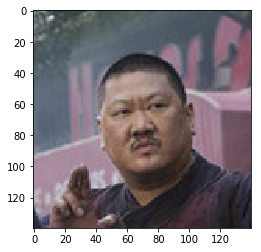

(1, 32, 110, 110)


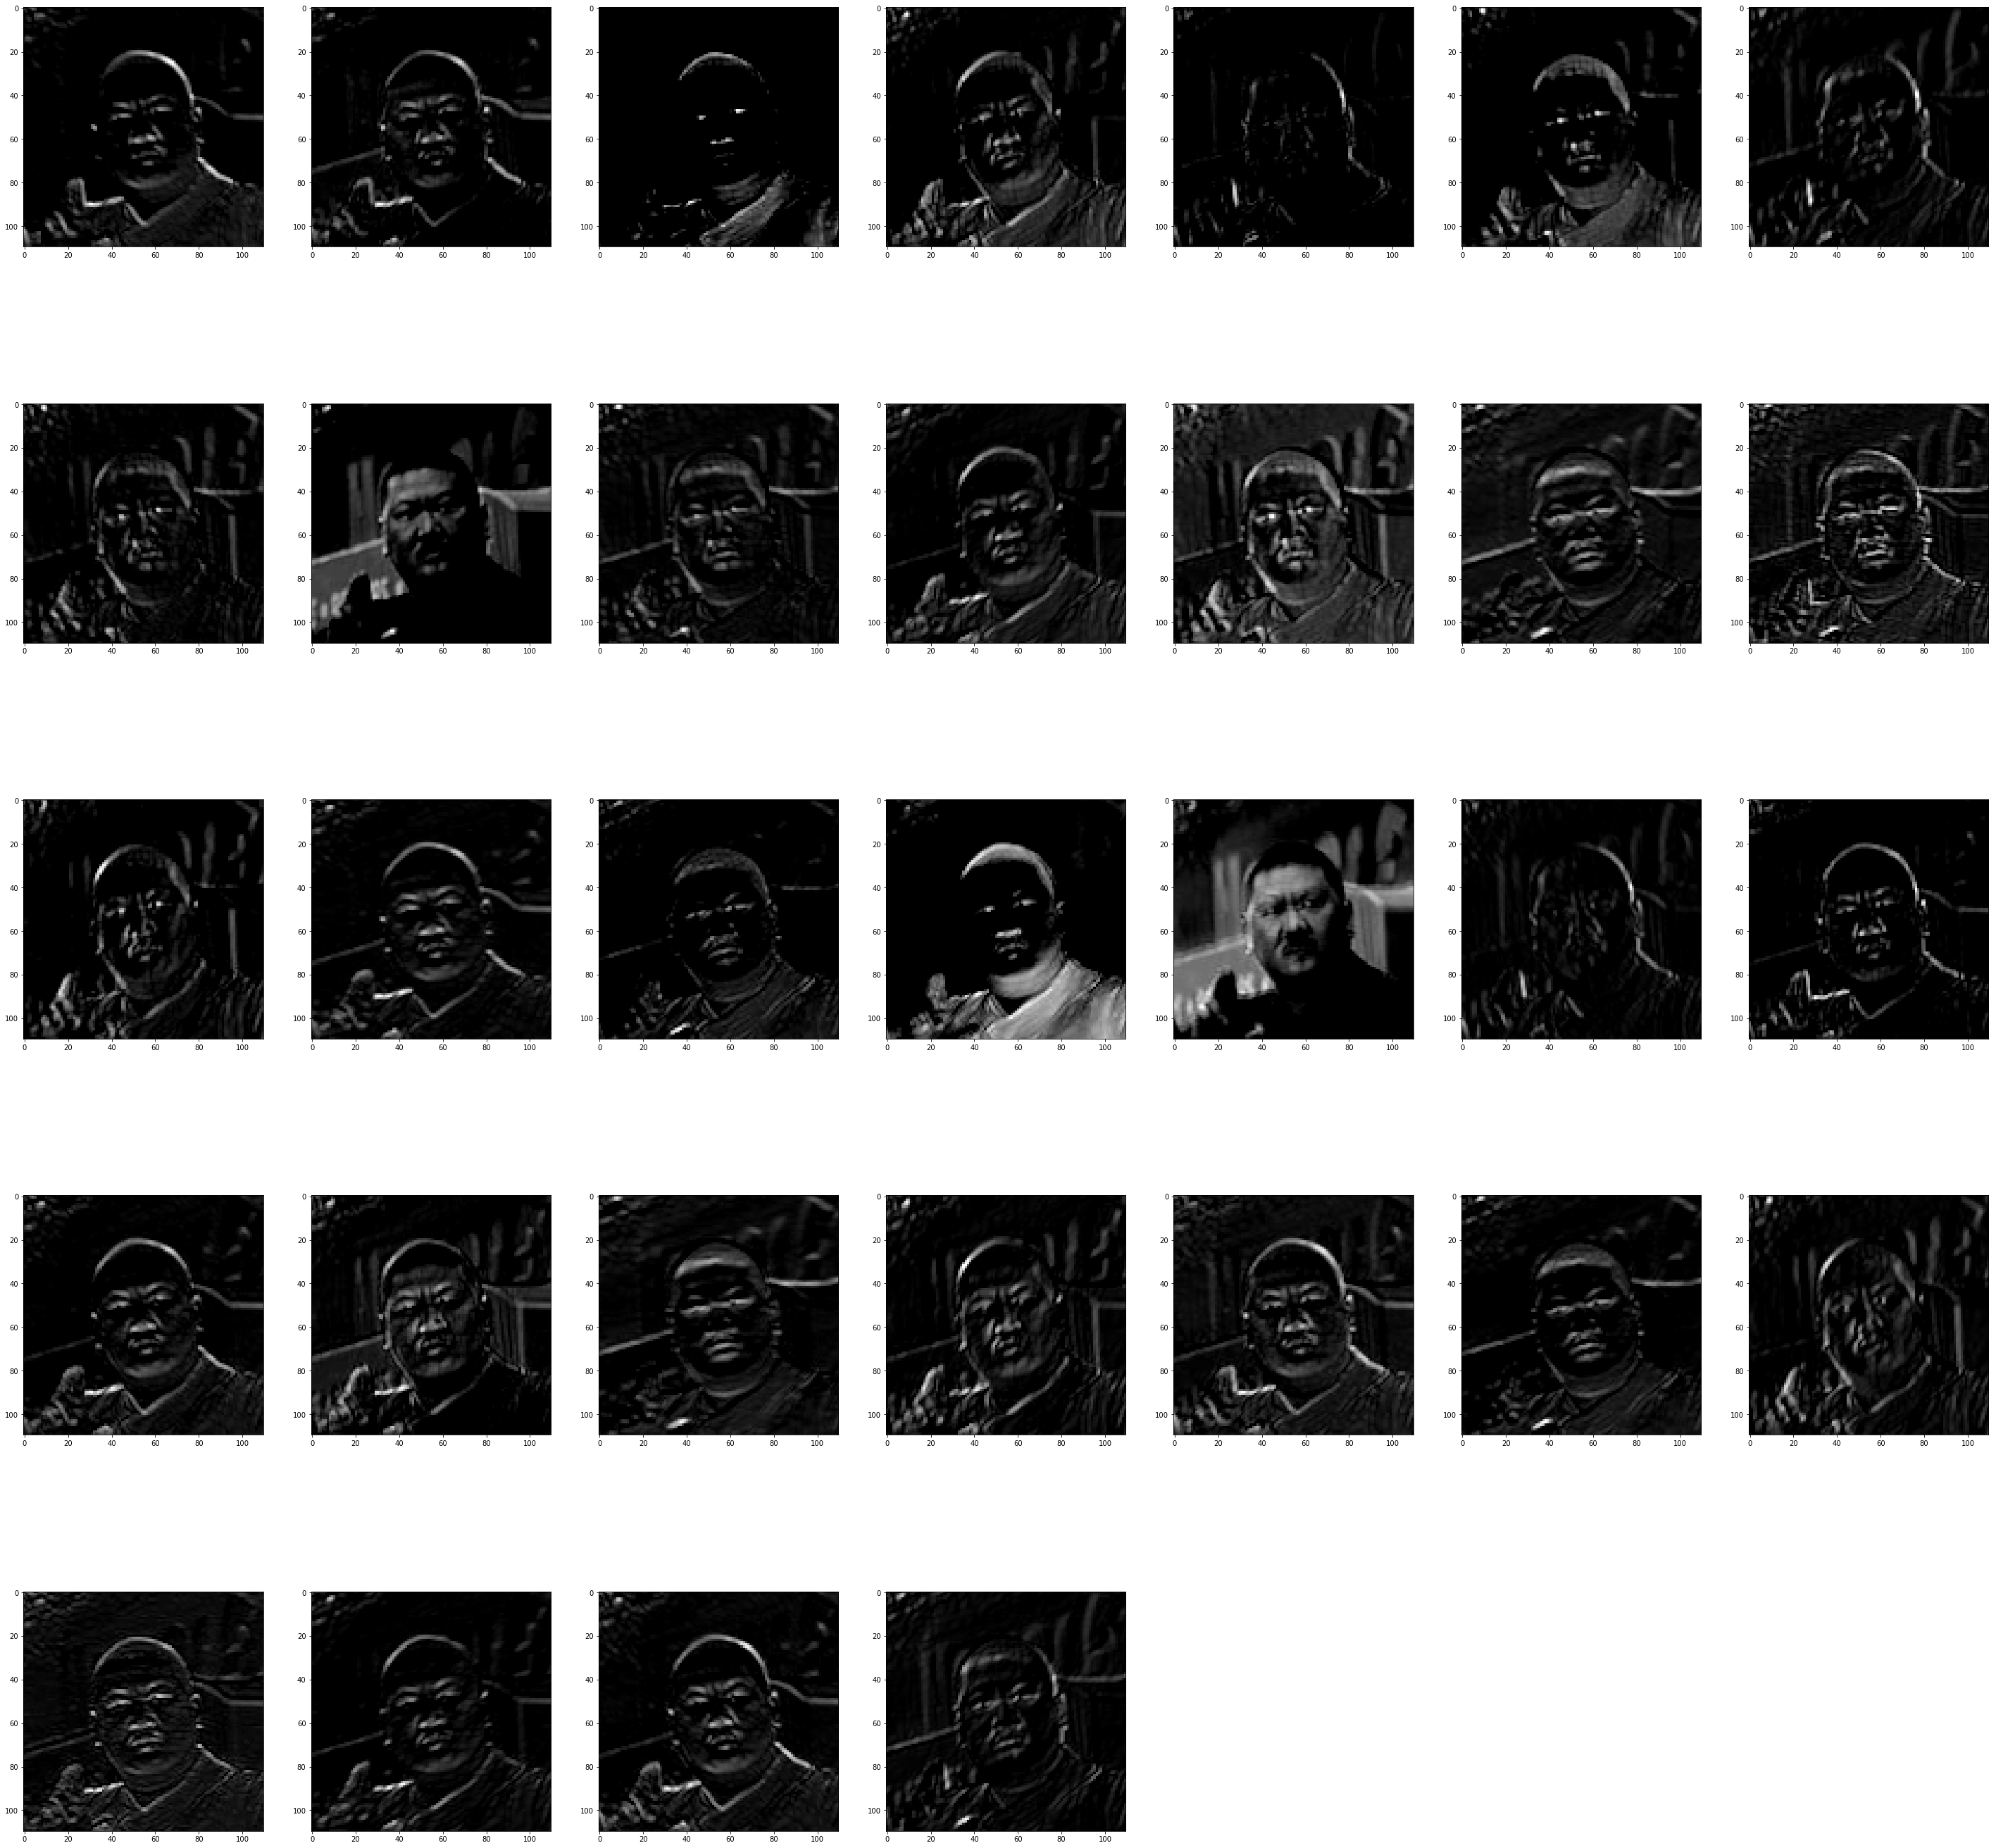

In [10]:
#conv1
show_feature(0,5,7)

(140, 140, 3)


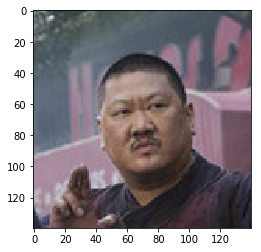

(1, 40, 53, 53)


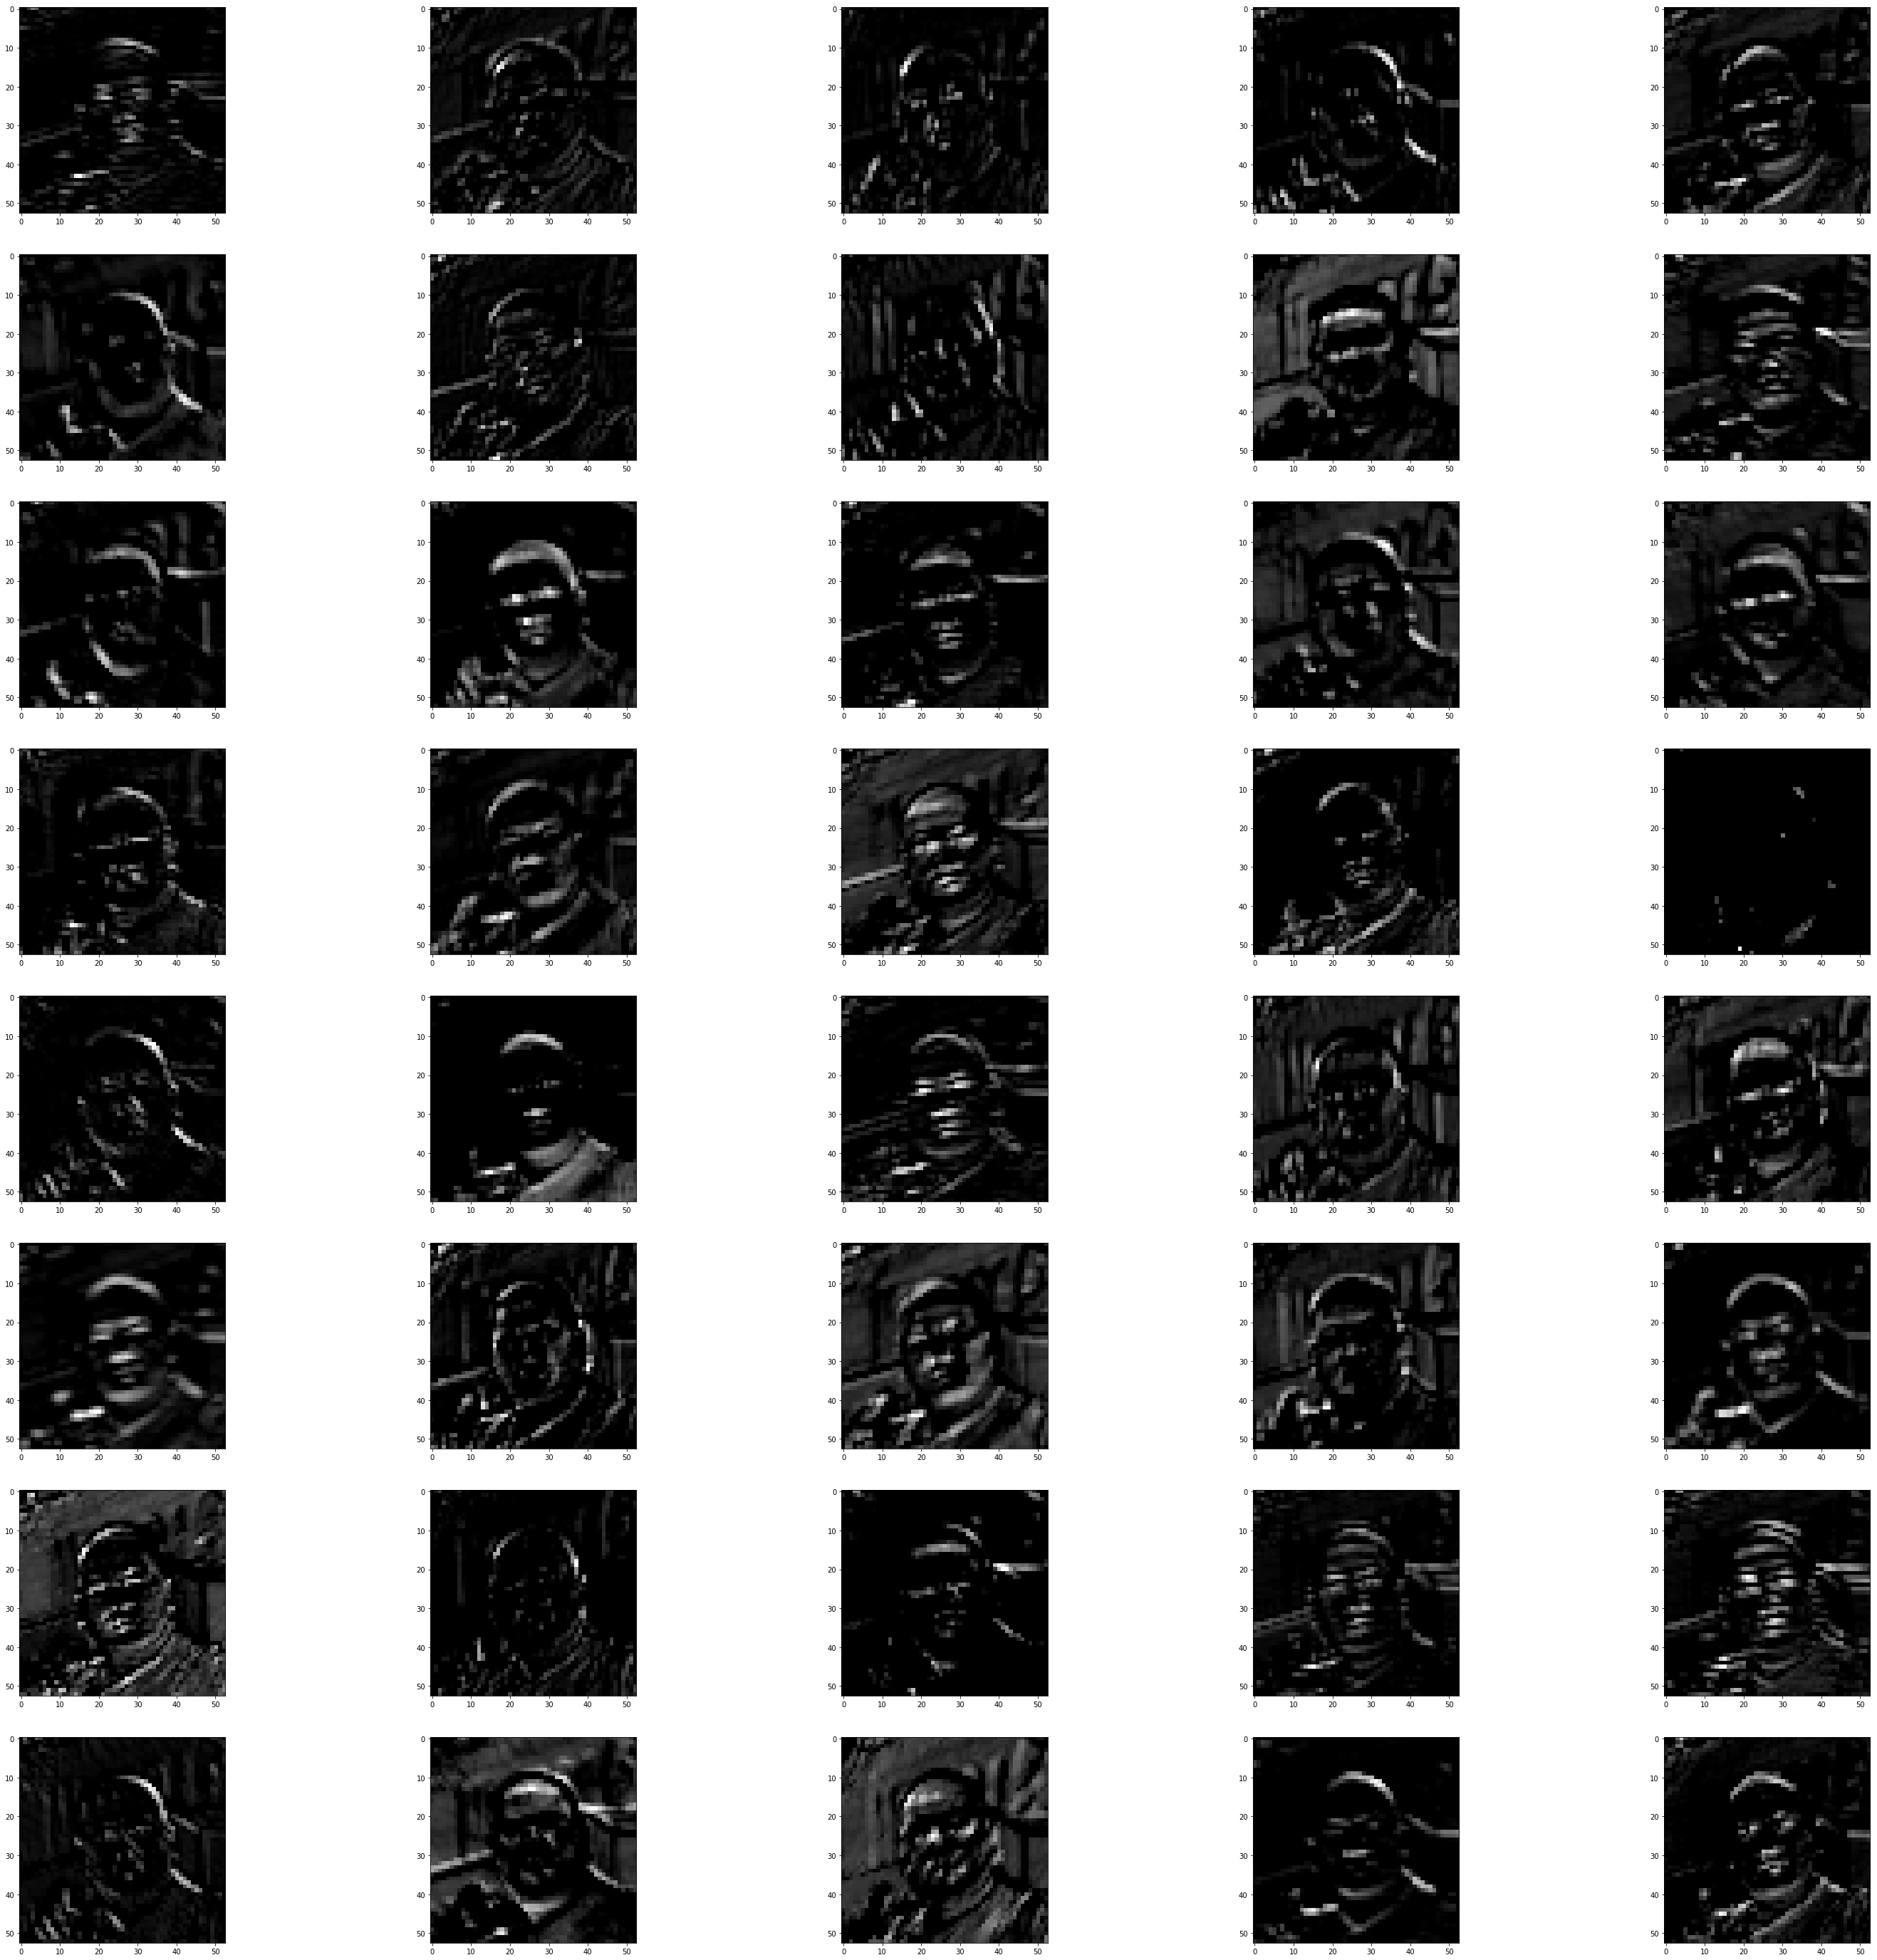

In [11]:
#conv2
show_feature(1,8,5)

(140, 140, 3)


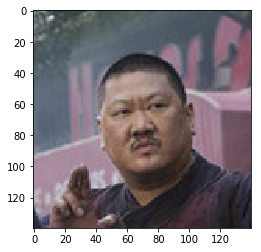

(1, 64, 25, 25)


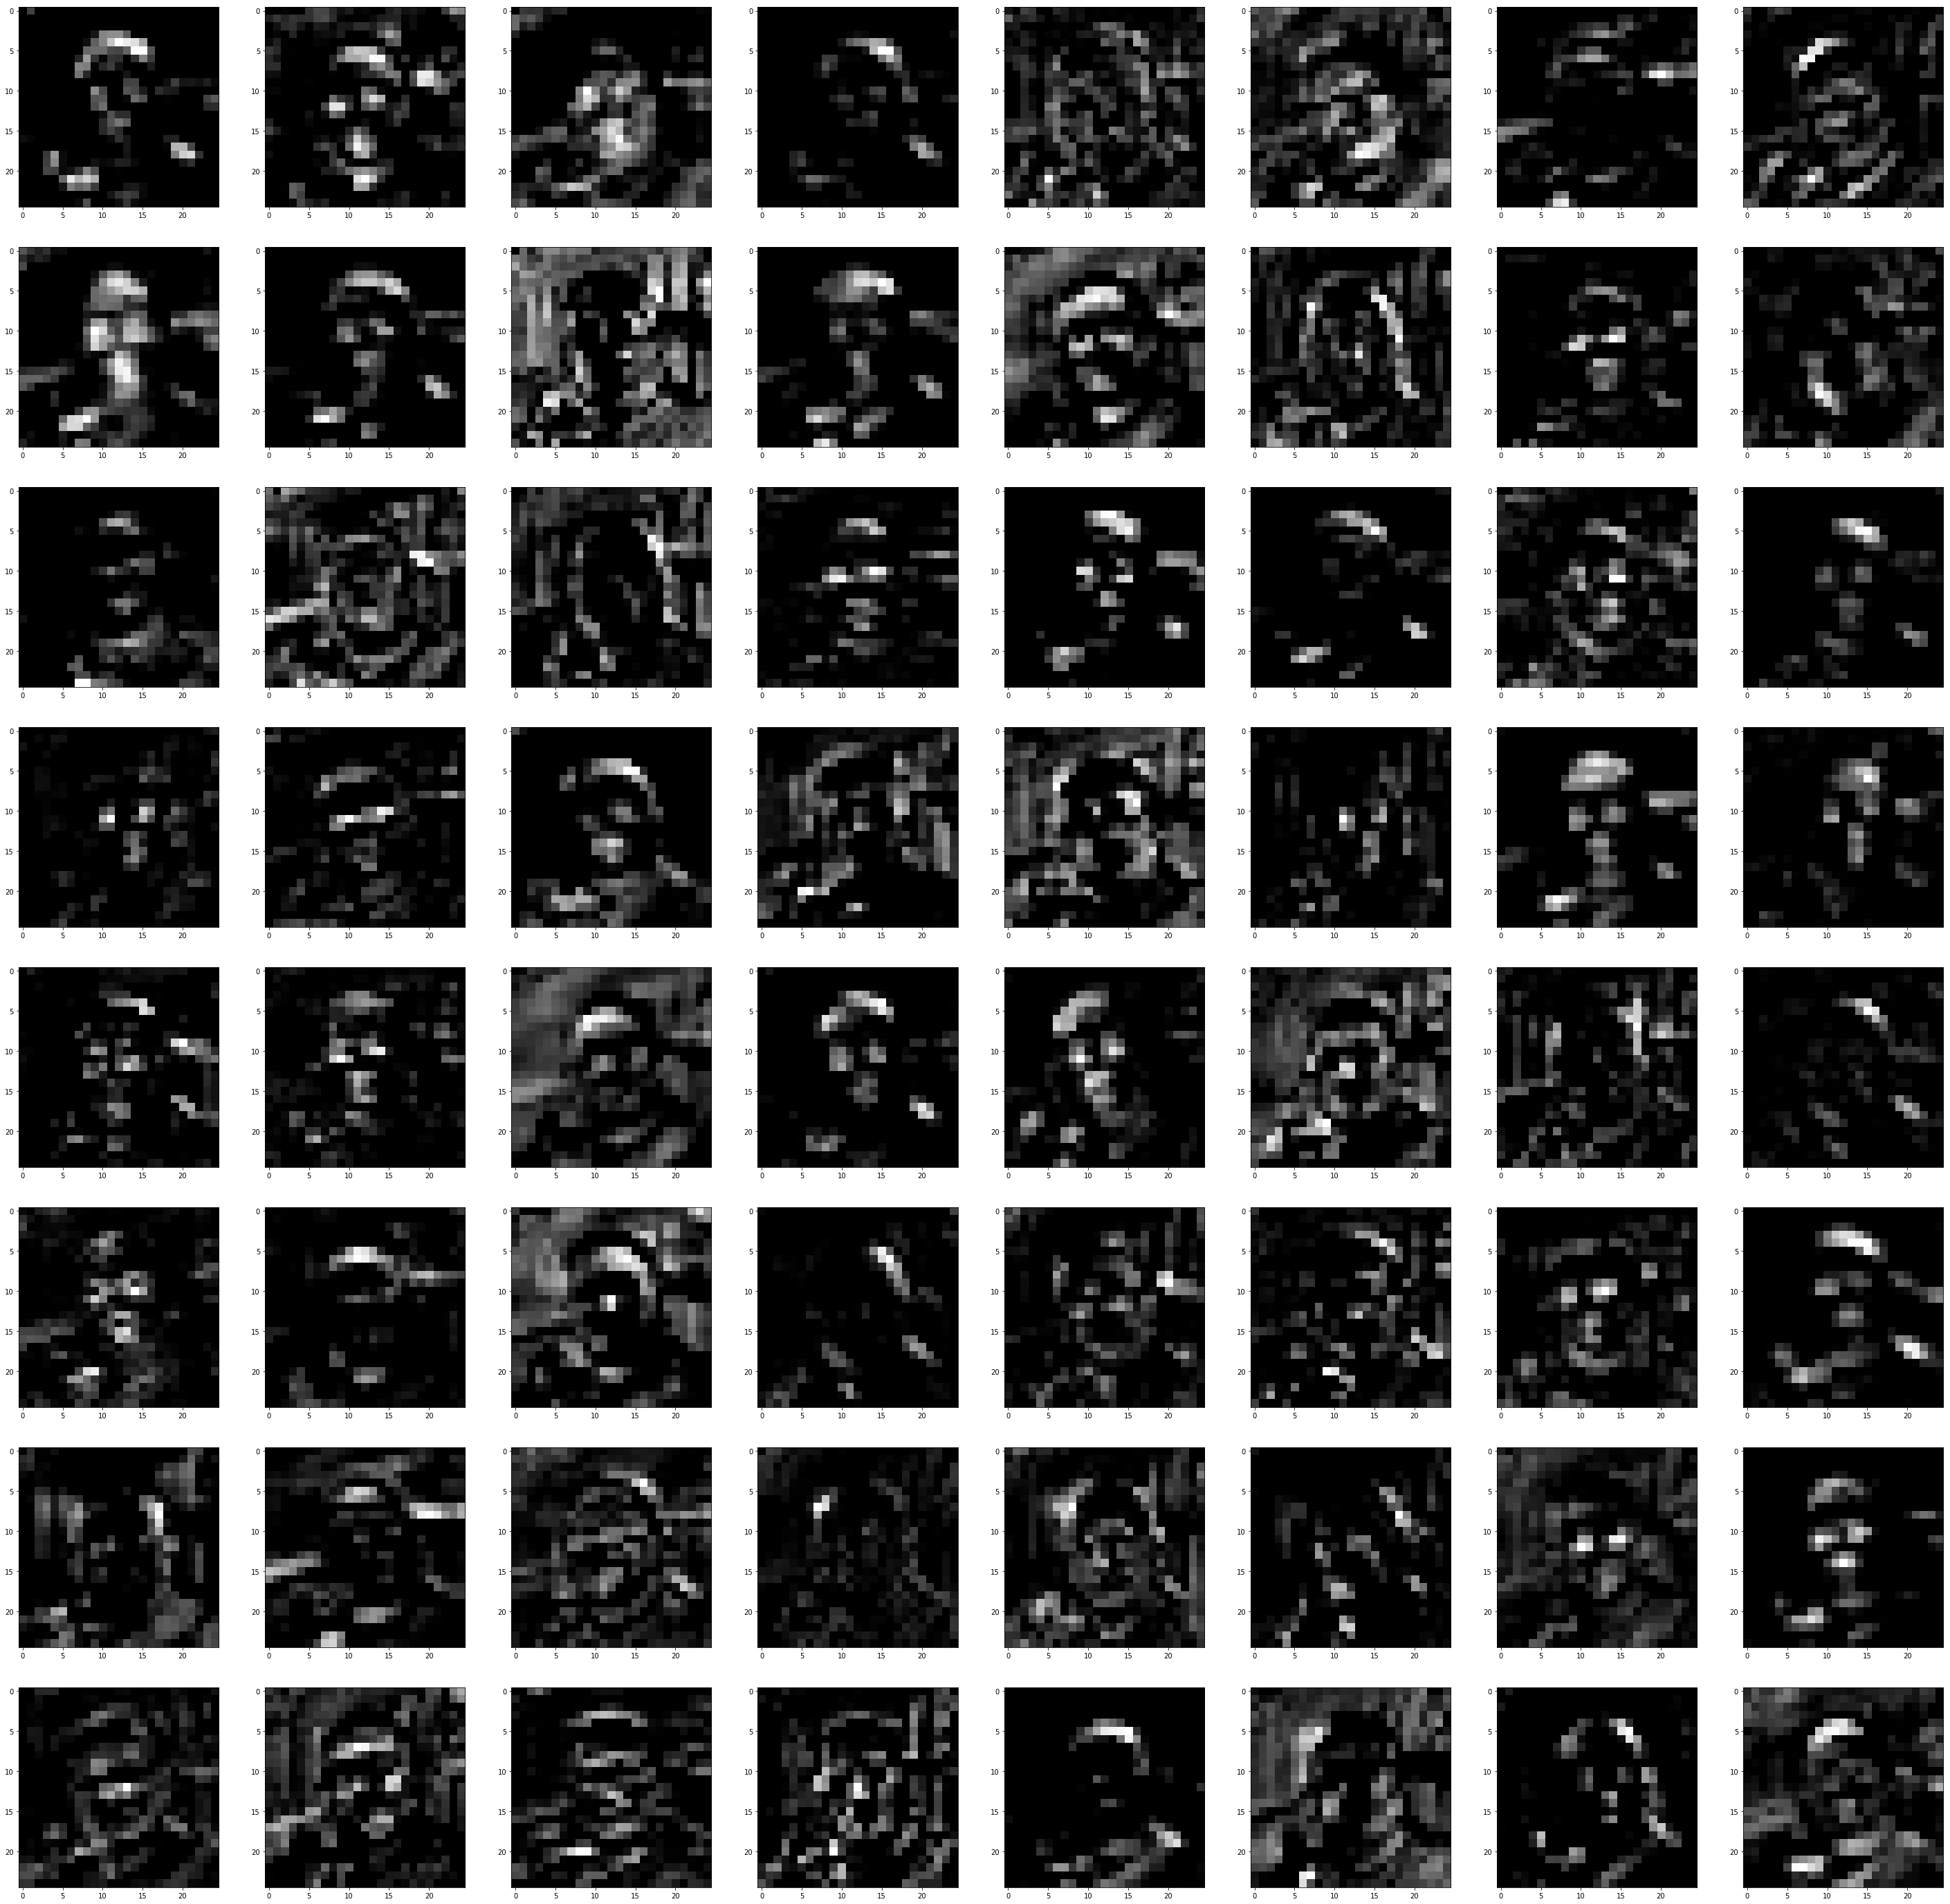

In [12]:
#conv3
show_feature(2,8,8)

(140, 140, 3)


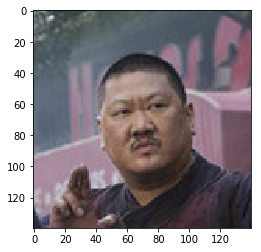

(1, 128, 11, 11)


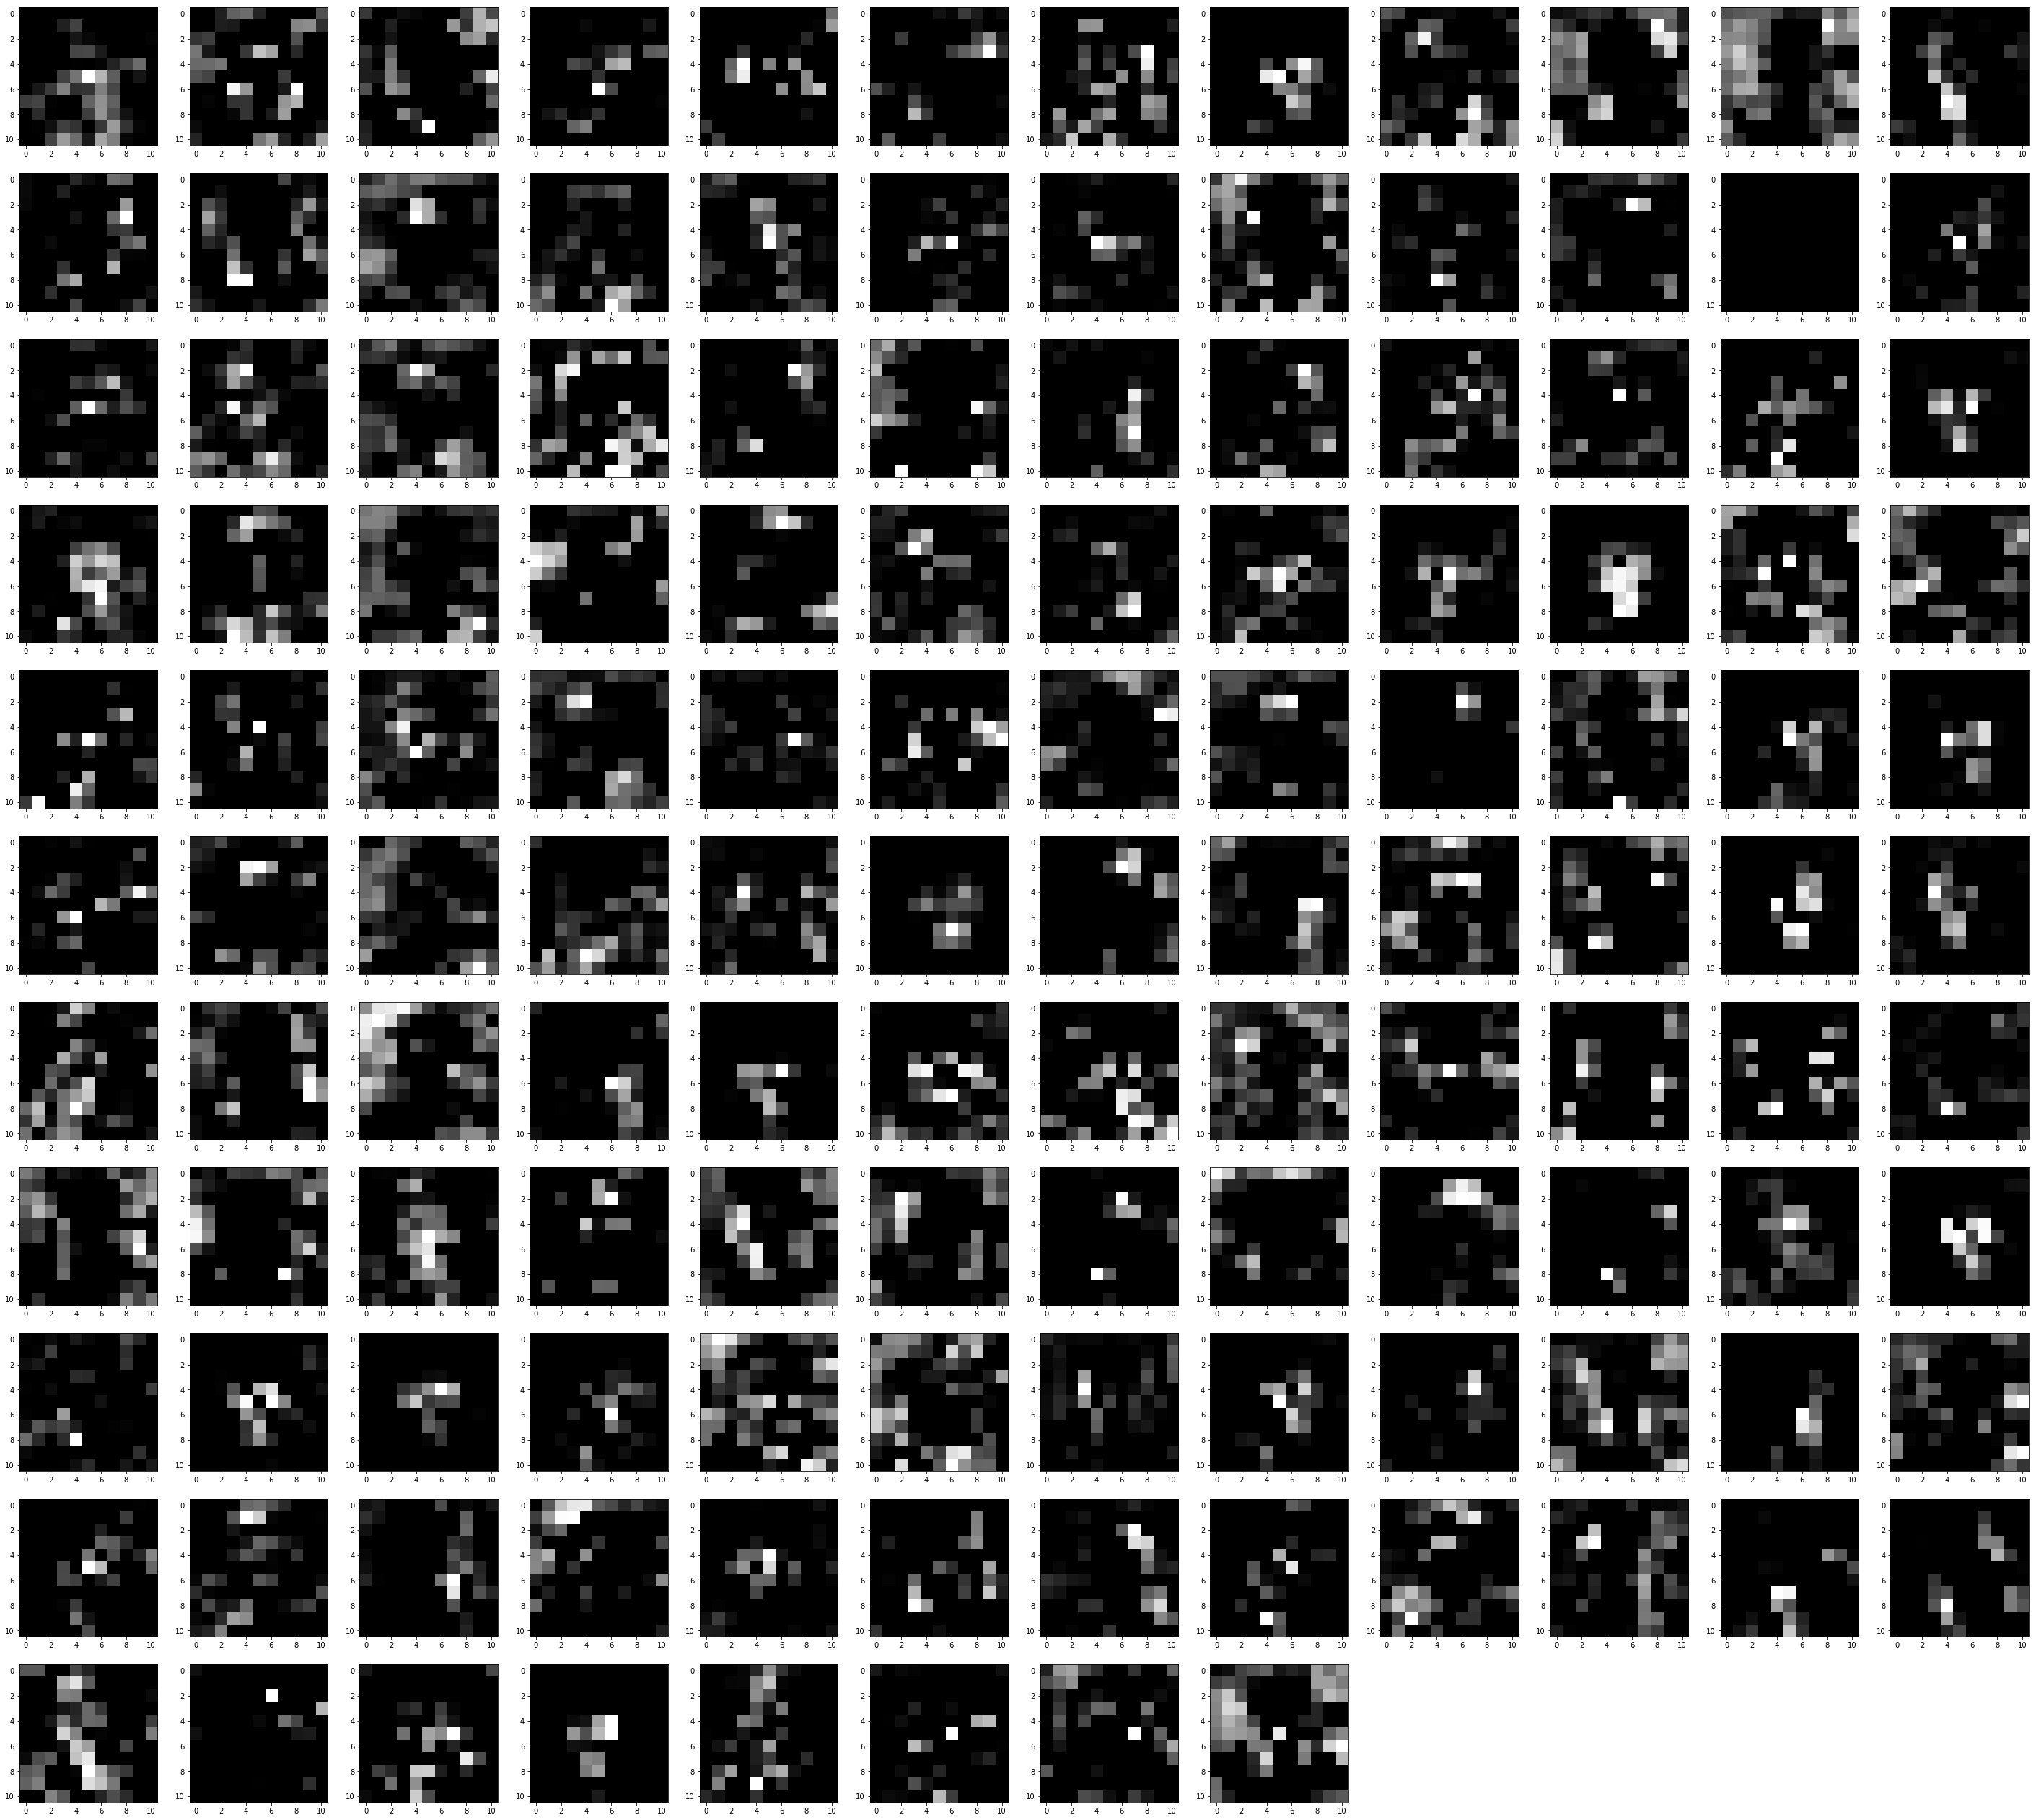

In [13]:
#conv4
show_feature(3,12,12)

Image shape:  (1123, 3064, 4)


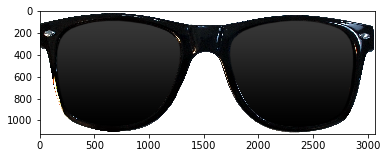

In [14]:
#put something on the face

# load in sunglasses image with cv2 and IMREAD_UNCHANGED
sunglasses = cv2.imread('images/sunglasses.png', cv2.IMREAD_UNCHANGED)

# plot our image
plt.imshow(sunglasses)

# print out its dimensions
print('Image shape: ', sunglasses.shape)


(64, 64)
(1, 1, 224, 224)
torch.Size([1, 1, 224, 224])
(45, 118, 3)
(75, 75)
(1, 1, 224, 224)
torch.Size([1, 1, 224, 224])
(43, 116, 3)
(81, 81)
(1, 1, 224, 224)
torch.Size([1, 1, 224, 224])
(46, 115, 3)
(60, 60)
(1, 1, 224, 224)
torch.Size([1, 1, 224, 224])
(50, 129, 3)


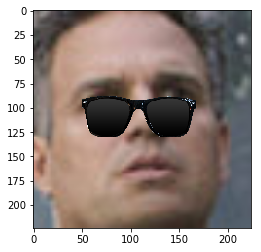

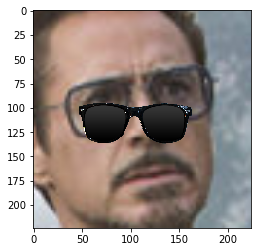

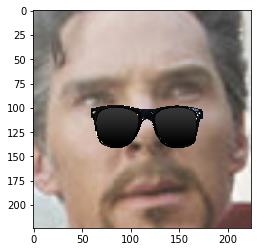

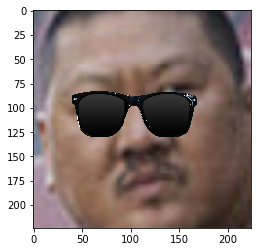

In [15]:
image_copy = np.copy(image)
new_w, new_h = cropsize,cropsize
# loop over the detected faces from your haar cascade
for (x,y,w,h) in faces:
    
    # Select the region of interest that is the face in the image 
    roi = image_copy[y:y+h, x:x+w]
    roi_draw_color = roi.copy()
    #print("111")
    ## TODO: Convert the face region from RGB to grayscale
    #print(roi.shape)
    #plt.figure()
    #plt.imshow(roi)


    roi = cv2.cvtColor(roi,cv2.COLOR_RGB2GRAY)

    print(roi.shape)
    #plt.figure()
    #plt.imshow(roi,cmap='gray')
    
    
    #sample ={'image':roi,'keypoints':0}
    #roi_torch = test_transform(sample)
    #roi_torch = roi_torch['image']
    
    
    ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    # scale color range from [0, 255] to [0, 1]
    roi =  roi/255.0
    ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    roi = cv2.resize(roi, (new_w, new_h))
    roi_draw = roi.copy()
    #print(roi[0][0])

    #print(roi.shape)
    #plt.figure()
    #plt.imshow(roi,cmap='gray')
    ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    # if image has no grayscale color channel, add one
    if(len(roi.shape) == 2):
        # add that third color dim
        roi = roi.reshape(roi.shape[0], roi.shape[1],1, 1)


    # swap color axis because
    # numpy image: H x W x C
    # torch image: C X H X W
    roi = roi.transpose((3,2, 0, 1))
    print(roi.shape)

    roi_torch = torch.from_numpy(roi)
    

    #print(roi_torch.shape)
    roi_torch = roi_torch.type(torch.FloatTensor)
    print(roi_torch.shape)

    ## TODO: Make facial keypoint predictions using your loaded, trained network 
    ## perform a forward pass to get the predicted facial keypoints
    #output_pts = net(roi_torch.to(device))
    #roi_torch = Variable(roi_torch)
    
    
    predicted_key_pts,_,_,_,_ = net.forward(roi_torch)
    predicted_key_pts = predicted_key_pts.view(predicted_key_pts.size()[0], 68, -1)
    #print(predicted_key_pts)
    predicted_key_pts=predicted_key_pts.data.numpy()
    mean  = cropsize/2#50#100,50
    std = cropsize/2#15#50,15
    predicted_key_pts = predicted_key_pts*std+mean
    predicted_key_pts =predicted_key_pts[0]
    #predicted_key_pts[:, 0]
    #print(predicted_key_pts.shape)
    
    
    
    
    #################################################################
    # Display sunglasses on top of the image in the appropriate place
    ###############################################################
    # copy of the face image for overlay
    #image_copy = np.copy(image)

    roi_draw_color = cv2.resize(roi_draw_color, (new_w, new_h))
    # top-left location for sunglasses to go
    # 17 = edge of left eyebrow
    x = int(predicted_key_pts[17, 0])
    y = int(predicted_key_pts[17, 1])

    # height and width of sunglasses
    # h = length of nose
    h = int(abs(predicted_key_pts[27,1] - predicted_key_pts[34,1]))
    # w = left to right eyebrow edges
    w = int(abs(predicted_key_pts[17,0] - predicted_key_pts[26,0]))

    # read in sunglasses
    sunglasses = cv2.imread('images/sunglasses.png', cv2.IMREAD_UNCHANGED)
    # resize sunglasses
    new_sunglasses =  cv2.resize(sunglasses, (w, h), interpolation = cv2.INTER_CUBIC)

    # get region of interest on the face to change
    roi_color = roi_draw_color[y:y+h,x:x+w]
    print(roi_color.shape)
    # find all non-transparent pts
    ind = np.argwhere(new_sunglasses[:,:,3] > 0)

    # for each non-transparent point, replace the original image pixel with that of the new_sunglasses
    for i in range(3):
        roi_color[ind[:,0],ind[:,1],i] = new_sunglasses[ind[:,0],ind[:,1],i]    
    # set the area of the image to the changed region with sunglasses
    roi_draw_color[y:y+h,x:x+w] = roi_color


    # display the result!
    plt.figure()
    plt.imshow(roi_draw_color)